## Imports and settings

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import json
import pprint

import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from matplotlib import gridspec
import pprint

detector_path = '..'
results_path = os.path.join(detector_path, 'results')
sys.path.append(detector_path)

from utils import constants
from utils import errors
from sleep.mass import MASS
from sleep.inta import INTA
from sleep import postprocessing
from evaluation import metrics
from evaluation import data_manipulation

SEED = 123

%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Load database and predicted probabilities

In [2]:
# Select database
dataset_name = constants.MASS_NAME
# Select predictions ckpt folder
ckpt_folder = os.path.join('20190325_v2bn_fixed_loading_train_mass', 'bsf_avg')
verbose = False

# Load data

# Marks are binary sequences for each page, 200 fs resolution
errors.check_valid_value(
    dataset_name, 'dataset_name',
    [constants.MASS_NAME, constants.INTA_NAME])
if dataset_name == constants.MASS_NAME:
    dataset = MASS(load_checkpoint=True)
else:
    dataset = INTA(load_checkpoint=True)

    # Get training set ids
print('Loading train set and splitting train/val')
all_train_ids = dataset.train_ids
# Split to form validation set
train_ids, val_ids = data_manipulation.split_ids_list(
    all_train_ids, seed=SEED)
print('Training set IDs:', train_ids)
print('Validation set IDs:', val_ids)
# Get test data
print('Loading test set')
test_ids = dataset.test_ids
print('Testing set IDs:', test_ids)

# Get subjects data, with the expert used for training
print('Loading signals and marks')
set_list = ['train', 'val', 'test']
x = {}
y = {}
pages = {}
x['train'], y['train'] = dataset.get_subset_data(train_ids, which_expert=1, verbose=verbose)
x['val'], y['val'] = dataset.get_subset_data(val_ids, which_expert=1, verbose=verbose)
x['test'], y['test'] = dataset.get_subset_data(test_ids, which_expert=1, verbose=verbose)
print('Loading pages')
pages['train'] = dataset.get_subset_pages(train_ids, verbose=verbose)
pages['val'] = dataset.get_subset_pages(val_ids, verbose=verbose)
pages['test'] = dataset.get_subset_pages(test_ids, verbose=verbose)

# Prepare expert labels into marks
print('Preparing labels', flush=True)
y_stamps = {}
for set_name in set_list:
    y_stamps[set_name] = postprocessing.generate_mark_intervals_with_list(
        y[set_name], pages[set_name], 200, 200, thr=None, postprocess=False)

# Load predictions (probability vectors for each page), 200/factor resolution (default factor 8)
ckpt_path = os.path.abspath(os.path.join(results_path, 'predictions_%s' % dataset_name, ckpt_folder))
print('Loading predictions from %s' % ckpt_path)
y_pred = {}
for set_name in set_list:
    y_pred[set_name] = np.load(os.path.join(ckpt_path, 'y_pred_%s.npy' % set_name), allow_pickle=True)
    # Keep only class 1 probability
    y_pred[set_name] = [this_y_pred[..., 1] for this_y_pred in y_pred[set_name]]
print('Done')

Dataset mass with 15 patients.
Train size: 11. Test size: 4
Train subjects: 
 [1, 3, 5, 7, 9, 10, 11, 14, 17, 18, 19]
Test subjects: 
 [2, 6, 12, 13]
Loading from checkpoint
Loaded
Loading train set and splitting train/val
Split IDs: Total 11 -- Training 8
Training set IDs: [1, 9, 10, 14, 17, 18, 7, 3]
Validation set IDs: [11, 19, 5]
Loading test set
Testing set IDs: [2, 6, 12, 13]
Loading signals and marks
Loading pages
Preparing labels
Loading predictions from /home/ntapia/Projects/GitNico/ssdetection-rnn/detector/results/predictions_mass/20190325_v2bn_fixed_loading_train_mass/bsf_avg
Done


## Performance: F1 vs IoU curve

In [7]:
# Performance settings
chosen_set = 'test'
thr = 0.5

# ---------------- Compute performance
print('Using thr %1.4f and %s set' % (thr, chosen_set))

# Prepare expert labels into marks
y_thr = y_stamps[chosen_set]

# Prepare model predictions
print('Preparing predictions', flush=True)
y_pred_thr = postprocessing.generate_mark_intervals_with_list(
    y_pred[chosen_set], pages[chosen_set], 200//8, 200, thr=thr)
n_subjects = len(y_thr)

# Go through several IoU values
print('Computing F1 Curve', flush=True)
iou_list = np.arange(1, 10) * 0.1
all_f1_list = [metrics.f1_vs_iou(this_y, this_y_pred, iou_list) 
               for (this_y, this_y_pred) 
               in zip(y_thr, y_pred_thr)]
all_f1_list = np.stack(all_f1_list, axis=1)
mean_f1 = np.mean(all_f1_list, axis=1)
std_f1 = np.std(all_f1_list, axis=1)
    
model_f1_mean = np.stack([iou_list, mean_f1], axis=1)
model_f1_std = np.stack([iou_list, std_f1], axis=1)
print('Mean F1')
pprint.pprint(model_f1_mean)
print('Std F1')
pprint.pprint(model_f1_std)

Using thr 0.5000 and test set
Preparing predictions
Computing F1 Curve
Mean F1
array([[0.1       , 0.78647249],
       [0.2       , 0.78581503],
       [0.3       , 0.7829656 ],
       [0.4       , 0.77707739],
       [0.5       , 0.76386745],
       [0.6       , 0.73717801],
       [0.7       , 0.68928685],
       [0.8       , 0.55037113],
       [0.9       , 0.23390704]])
Std F1
array([[0.1       , 0.03626973],
       [0.2       , 0.0359071 ],
       [0.3       , 0.03523572],
       [0.4       , 0.03651005],
       [0.5       , 0.03920547],
       [0.6       , 0.04362643],
       [0.7       , 0.04385236],
       [0.8       , 0.05355407],
       [0.9       , 0.03559432]])


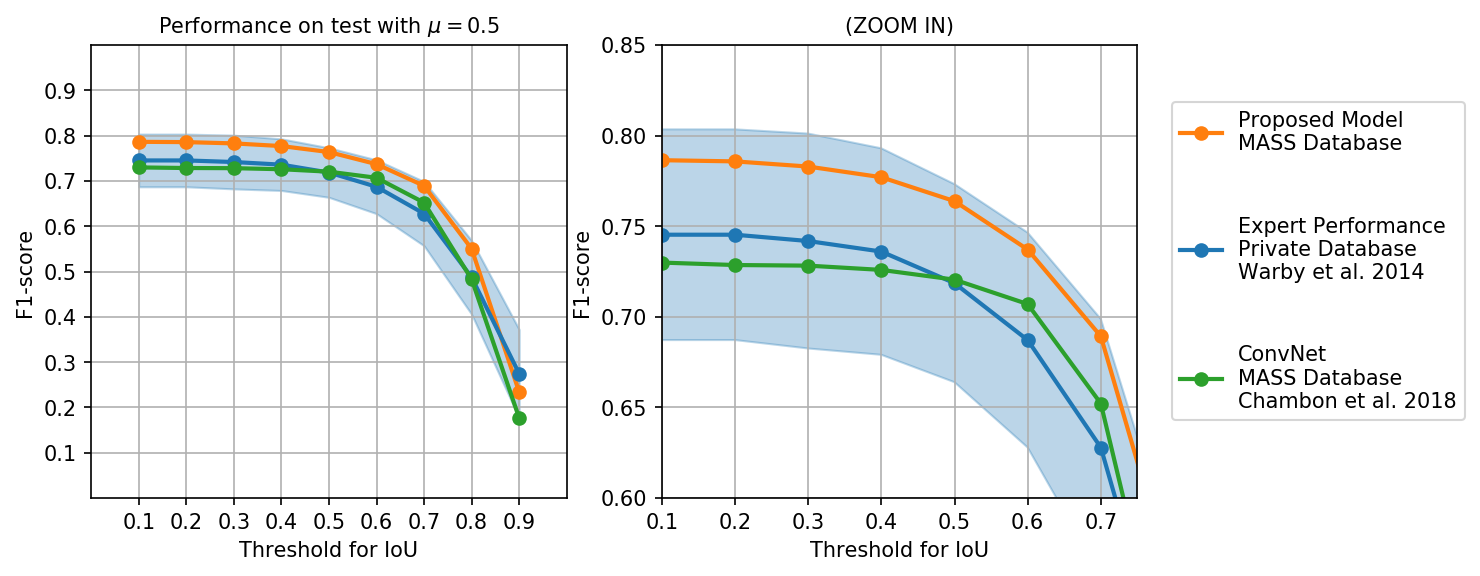

In [20]:
# Saving settings
save_f1_iou_result = False
ckpt_id = 'avg_2019mar'

# Comparison settings
comparison_folder = 'comparison_data'
compare_expert = True
compare_chambon = True
show_set_std = False


# --------------- Optional: Save F1 data
if save_f1_iou_result:
    filename = os.path.join('comparison_data', '%s_f1_vs_iou_model_%s.csv' % (dataset_name, ckpt_id))
    np.savetxt(filename, model_f1_mean, delimiter=",")


# -------------------- P L O T ----------------------    
# Comparison data
if compare_expert:
    expert_f1_curve_mean = np.loadtxt(os.path.join(comparison_folder, 'f1_vs_iou_expert_mean.csv'), delimiter=',')
    expert_f1_curve_std = np.loadtxt(os.path.join(comparison_folder, 'f1_vs_iou_expert_std.csv'), delimiter=',')
if compare_chambon:
    chambon_f1_curve = np.loadtxt(os.path.join(comparison_folder, 'mass_f1_vs_iou_Chambon.csv'), delimiter=',')

fig, ax = plt.subplots(1, 2, figsize=(9, 4), dpi=150)

# Complete plot
ax[0].plot(model_f1_mean[:, 0], model_f1_mean[:, 1], linewidth=2, markersize=12, marker='.', 
           label='Proposed Model', color='C1')
if show_set_std:
    ax[0].fill_between(
            model_f1_mean[:, 0], 
            model_f1_mean[:, 1] - model_f1_std[:, 1], 
            model_f1_mean[:, 1] + model_f1_std[:, 1], 
            alpha=0.3, color='C1')
if compare_expert:
    ax[0].plot(expert_f1_curve_mean[1:, 0], expert_f1_curve_mean[1:, 1], linewidth=2, markersize=12, marker='.', 
               label='Expert Performance', color='C0')
    ax[0].fill_between(
        expert_f1_curve_mean[1:, 0], 
        expert_f1_curve_mean[1:, 1] - expert_f1_curve_std[1:, 1], 
        expert_f1_curve_mean[1:, 1] + expert_f1_curve_std[1:, 1], 
        alpha=0.3, color='C0')
if compare_chambon:
    ax[0].plot(chambon_f1_curve[:, 0], chambon_f1_curve[:, 1], linewidth=2, markersize=12, marker='.', 
               label='Chambon et al.', color='C2')
ax[0].set_title('Performance on %s with $\mu=%1.1f$' % (chosen_set, thr), fontsize=10)
ax[0].set_xlim([0, 1])
ax[0].set_ylim([0, 1])
ax[0].set_yticks([0.1*i for i in range(1, 10)])
ax[0].set_xticks([0.1*i for i in range(1, 10)])
ax[0].set_xlabel('Threshold for IoU')
ax[0].set_ylabel('F1-score')
ax[0].grid()

# Zoom plot
ax[1].plot(model_f1_mean[:, 0], model_f1_mean[:, 1], linewidth=2, markersize=12, marker='.', 
           label='Proposed Model\n%s Database' % dataset_name.upper(), color='C1')
if show_set_std:
    ax[1].fill_between(
            model_f1_mean[:, 0], 
            model_f1_mean[:, 1] - model_f1_std[:, 1], 
            model_f1_mean[:, 1] + model_f1_std[:, 1], 
            alpha=0.3, color='C1')
if compare_expert:
    ax[1].plot(expert_f1_curve_mean[1:, 0], expert_f1_curve_mean[1:, 1], linewidth=2, markersize=12, marker='.', 
               label='Expert Performance\nPrivate Database\nWarby et al. 2014', color='C0')
    ax[1].fill_between(
        expert_f1_curve_mean[1:, 0], 
        expert_f1_curve_mean[1:, 1] - expert_f1_curve_std[1:, 1], 
        expert_f1_curve_mean[1:, 1] + expert_f1_curve_std[1:, 1], 
        alpha=0.3, color='C0')
if compare_chambon:
    ax[1].plot(chambon_f1_curve[:, 0], chambon_f1_curve[:, 1], linewidth=2, markersize=12, marker='.', 
               label='ConvNet\nMASS Database\nChambon et al. 2018', color='C2')
ax[1].set_title('(ZOOM IN)', fontsize=10)
ax[1].set_xlim([0.1, 0.75])
ax[1].set_ylim([0.6, 0.85])
ax[1].set_xlabel('Threshold for IoU')
ax[1].set_ylabel('F1-score')
ax[1].legend(loc='lower left', bbox_to_anchor=(1.05, 0.15), labelspacing=3)
ax[1].grid()

plt.show()

## Performance: Precision-Recall plot, independent subjects

In [3]:
thr = 0.5

iou_thr = 0.3

# Prepare model predictions
be_stats = {}
for set_name in set_list:
    print('Preparing predictions for %s set' % set_name, flush=True)
    y_pred_thr = postprocessing.generate_mark_intervals_with_list(
        y_pred[set_name], pages[set_name], 200//8, 200, thr=thr)
    be_stats[set_name] = [metrics.by_event_confusion(this_y, this_y_pred, iou_thr=iou_thr) 
                for (this_y, this_y_pred) in zip(y_stamps[set_name], y_pred_thr)]
    print('Done')

Preparing predictions for train set
Done
Preparing predictions for val set
Done
Preparing predictions for test set
Done


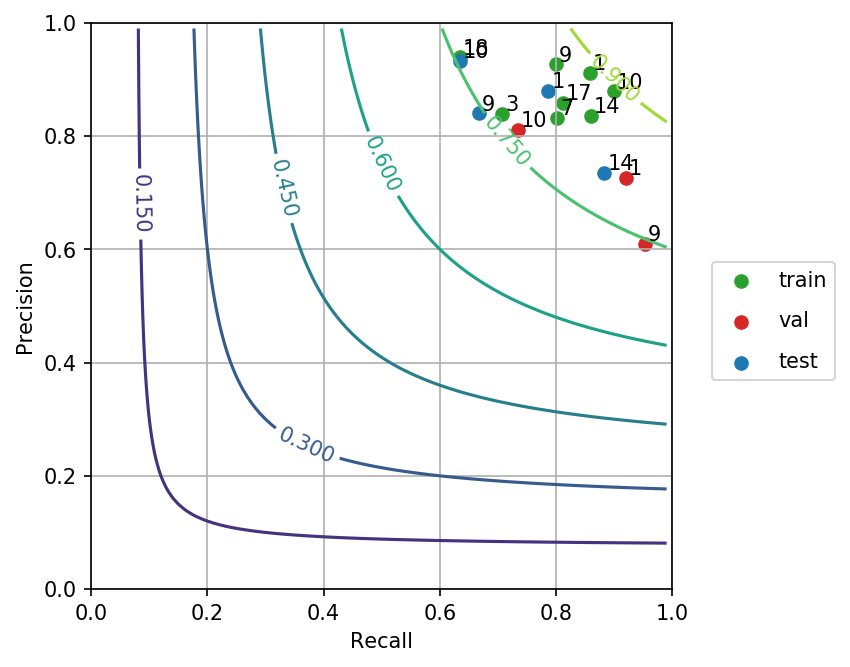

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=150)
text_space = 0.005

delta = 0.01 
x_ = np.arange(1, 100) * delta 
y_ = np.arange(1, 100) * delta 
X, Y = np.meshgrid(x_, y_)
Z = 2 * X * Y / (X + Y)

CS = ax.contour(X, Y, Z)
ax.clabel(CS, inline=1, fontsize=10)

color_list = ['C2', 'C3', 'C0']
for j, set_name in enumerate(set_list):
    for i, stats in enumerate(be_stats[set_name]):
        if i==0:
            ax.scatter(stats['recall'], stats['precision'], c=color_list[j], label=set_name)
        else:
            ax.scatter(stats['recall'], stats['precision'], c=color_list[j])
        ax.annotate(train_ids[i], (stats['recall']+text_space, stats['precision']+text_space))  

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid()
plt.legend(loc='lower left', bbox_to_anchor=(1.05, 0.35), labelspacing=1)
plt.show()

## Performance: Precision-Recall curve, average per set

In [21]:
# TODO: dibujar curva para un arreglo de umbrales